# P4: Advanced Lane Lines

## Camera Calibration 

In [1]:
import numpy as np
import cv2
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob

from scipy.signal import argrelmax
from scipy.signal import find_peaks_cwt

%matplotlib inline

In [2]:
def calibrate_camera(calibration_images, nx, ny):
    """
    Arguments:
        calibration_images -- list of strings of image paths to use for calibration
        
    returns: 
        (ret, mtx, dist, rvecs, tvecs)

        mtx -- camera matrix
        dist -- distortion coefficients
        rvecs -- rotation vectors
        tvecs -- translational vectors
    
    """
    
    # Arrays to store object points and image points from all the images
    objpoints = [] # 3D points in real world space
    imgpoints = [] # 2D points in image plane
        
    # Prepare object points by creating  6x8 points in an array each with 3 columns for the x,y,z coordinates of each corner
    objp = np.zeros((ny*nx, 3), np.float32)
    
    # Use numpy mgrid function to generate the coordinates that we want
    objp[:, :2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)
    
    for name in calibration_images:
        
        img = mpimg.imread(name)

        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

        #If corners are found, add image points and object points
        if(ret):
            imgpoints.append(corners)
            
            # Object points will be the same for all of the calibration images
            # Since they represent a real chessboard
            objpoints.append(objp)
            
    return cv2.calibrateCamera(objpoints, imgpoints, img.shape[0:2], None, None)

In [3]:
# Number of inner corners per row and column
nx = 9
ny = 6
calibration_images = glob.glob("camera_cal/*")

# Calibrate the camera
ret, mtx, dist, rvecs, tvecs = calibrate_camera(calibration_images, nx, ny)

## Un-Distort

In [4]:
def undistort(image):
    """
        Simple wrapper that un distorts an image
        Using previously computed camera matrix and
        distortion coefficients
    """
    return cv2.undistort(image, mtx, dist)

In [5]:
def plot_on_subplots(images, titles, cmap=None):
    """Helper function that plots pairs of images.
    
    Parameters:
        images -- List of 2 images
        titles -- List of two titles
    
    """
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    
    if cmap:
        ax1.imshow(images[0], cmap=cmap)
    else:
        ax1.imshow(images[0])
    ax1.set_title(titles[0])

    if(cmap):
        ax2.imshow(images[1], cmap=cmap)
    else:
        ax2.imshow(images[1])
        
    ax2.set_title(titles[1])

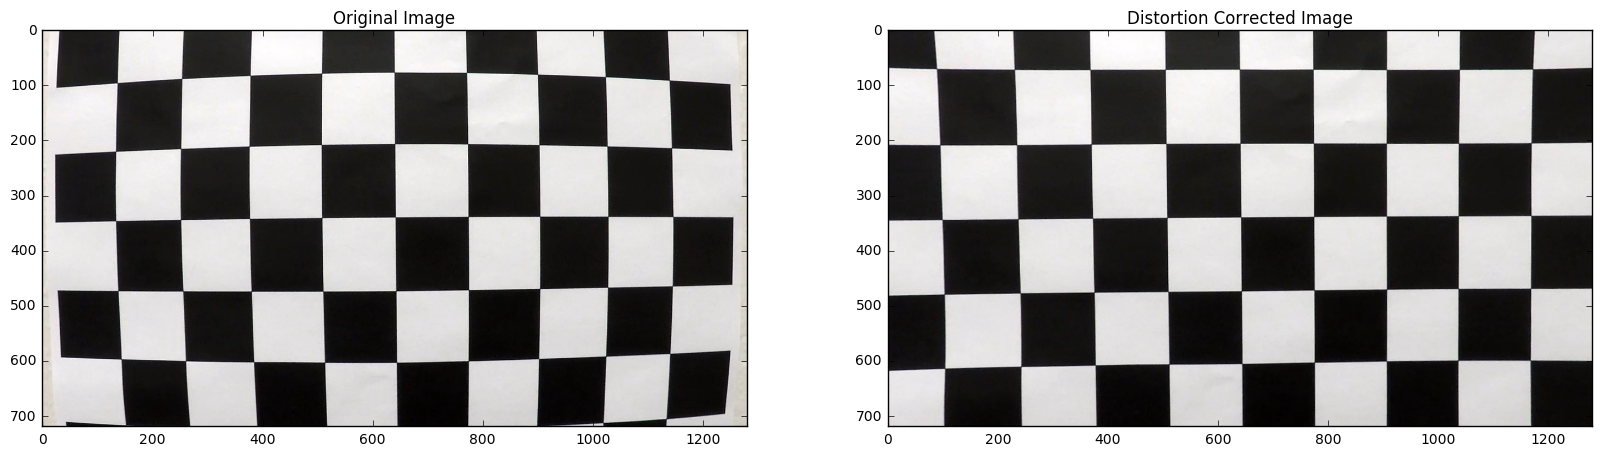

In [6]:
# Perform distortion Correction on one of the calibration images
calibration_image = plt.imread("camera_cal/calibration1.jpg")

plot_on_subplots([calibration_image, undistort(calibration_image)], ["Original Image", "Distortion Corrected Image"])

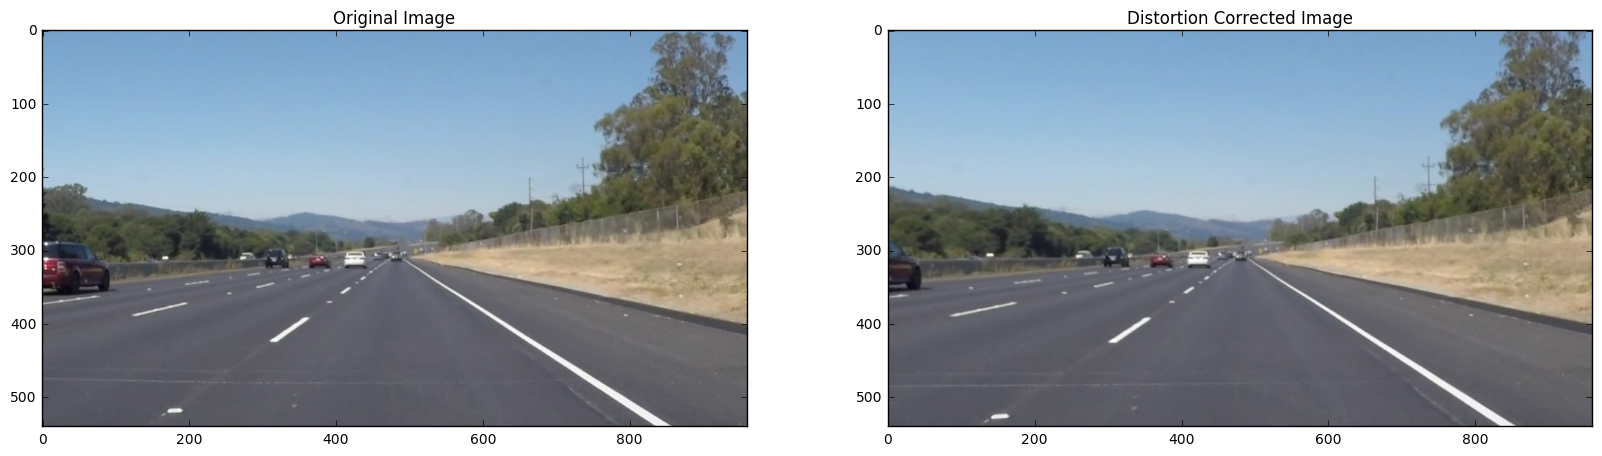

In [7]:
# Perform un-distortion on a test images
test_image = plt.imread("test_images/solidWhiteRight.jpg")
plot_on_subplots([test_image, undistort(test_image)], ["Original Image", "Distortion Corrected Image"])

In [8]:
def gaussian_blur(img, kernel_size=5):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

## Binary Image generator

In [9]:
test_image = mpimg.imread("test_images/shadow.jpg")
image = undistort(test_image)

In [10]:
def get_grayscale_thresholded_img(img, thresh=(130, 255)):
    """Converts image to grayscale and thresholds the resulting output
    
    Parameters:
        img -- image to be thresholded
        thresh -- tuple of (lower bound, upper bound) for the threshold
    
    """
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    binary = np.zeros_like(gray)
    
    binary[(gray > thresh[0]) & (gray < thresh[1])] = 1
    
    return binary

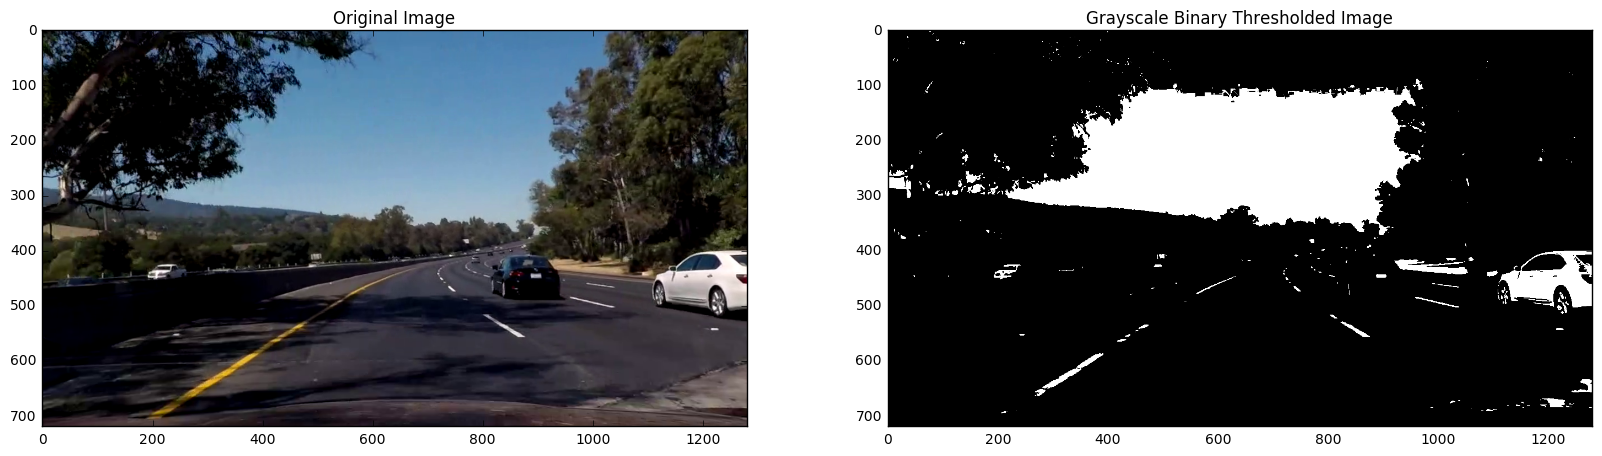

In [11]:
grayscale_binary = get_grayscale_thresholded_img(image)
plot_on_subplots([image, grayscale_binary], ["Original Image", "Grayscale Binary Thresholded Image"], cmap="gray")

In [12]:
def get_sobel_binary(image, thresh_min=20, thresh_max=200):
    """Applies a sobel filter in the x direstion,
    takes the absolute value, scales to an 8 bit image 
    and thresholds the output to produce a binary image
    
    Parameters:
        image --  image to be converted to binary image
        thresh_min -- lower bound of the threshold
        thresh_max -- upper bound of the threshold
    
    """
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # Take the sobel derivative in the x direction
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) 
    
    # Absolute x derivative to accentuate lines away from horizontal
    abs_sobelx = np.absolute(sobelx) 
    
    # Scale to 8 bit grayscale image
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Apply a threshold
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    
    return sxbinary

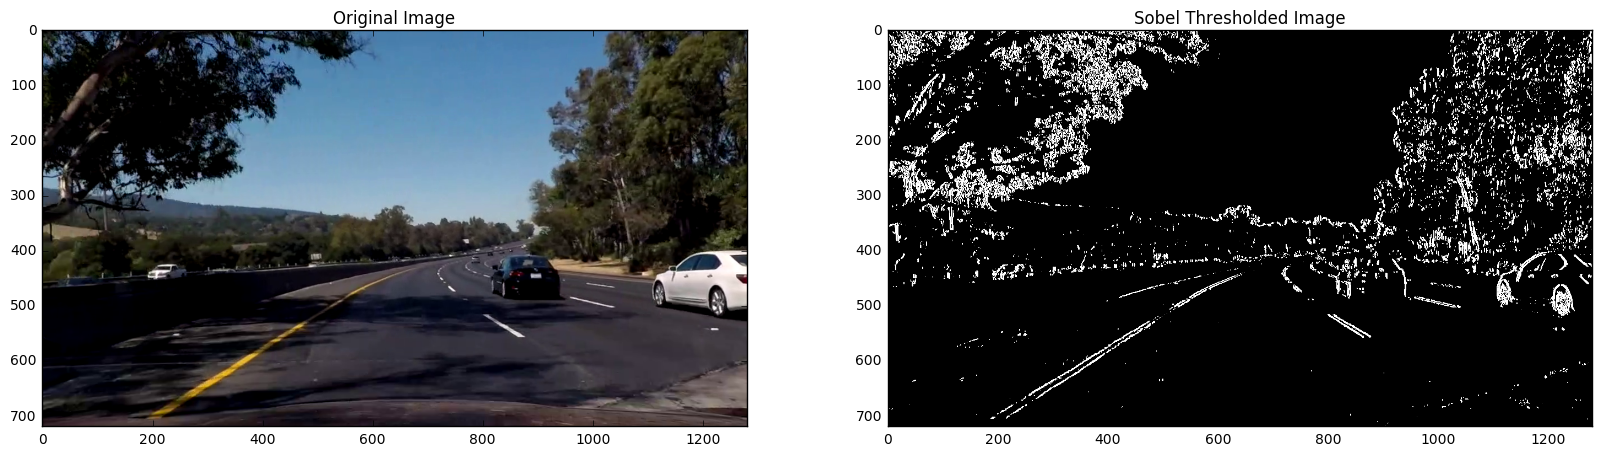

In [13]:
sobel_binary = get_sobel_binary(image)
plot_on_subplots([image, sobel_binary], ["Original Image", "Sobel Thresholded Image"], cmap="gray")

In [14]:
def get_channel_index_hls(chanel_name):
    """Returns the index of each channel
        for an image in HLS color channel
        
        Parameters:
            channel name -- channel for which index is desired
    """
    if(chanel_name == "h"):
        return 0
    elif(chanel_name == "l"):
        return 1
    elif(chanel_name == "s"):
        return 2

In [15]:
def get_hls_channel_binary(image, channel_name='s', thresh_min=180, thresh_max=255):
    """Converts image to HLS color space and performs thresholding on one 
    of the channels depending on the channel requested.
    
    Parameters:
        image -- image to be converted to binary
        channel_name -- HLS channel on which thresholding is to be performed
        thresh_min -- lower bound of the threshold
        thresh_max -- upper bound of the threshold
    
    """
    
    # Convert to HLS color space
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    
    # Extract the desired channel
    channel_index = get_channel_index_hls(channel_name)
    channel = hls[:,:,channel_index]
    
    # Apply the threshold
    channel_binary = np.zeros_like(channel)
    channel_binary[(channel >= thresh_min) & (channel <= thresh_max)] = 1
    
    return channel_binary    

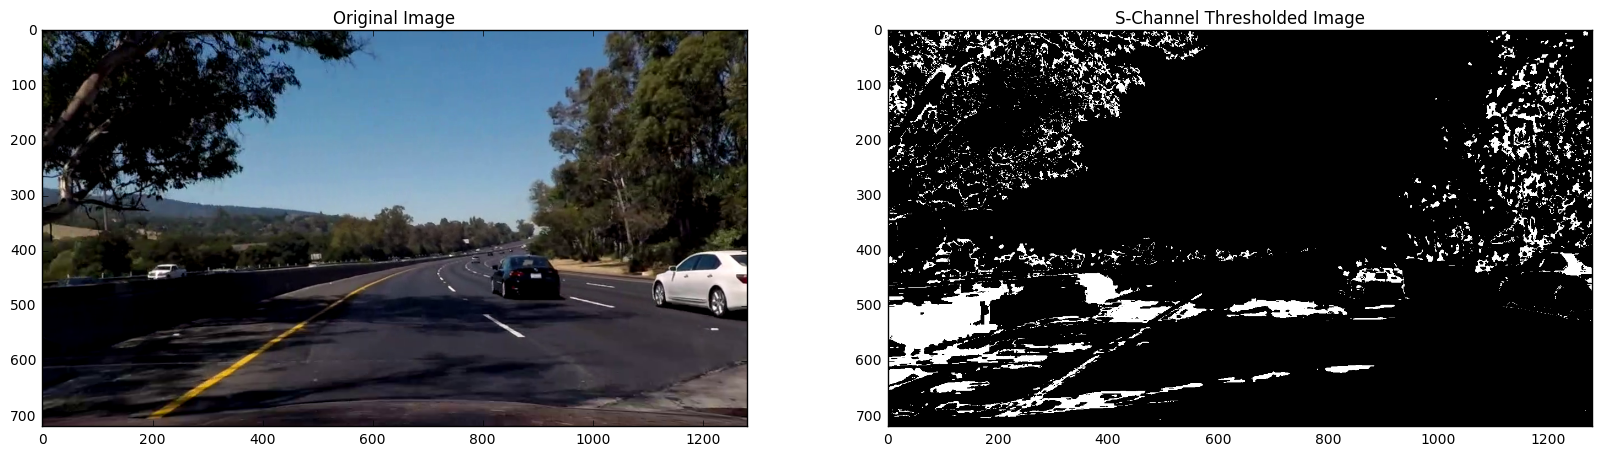

In [16]:
s_binary = get_hls_channel_binary(image)
plot_on_subplots([image, s_binary], ["Original Image", "S-Channel Thresholded Image"], cmap="gray")

In [17]:
def get_color_selection(image):
    """Performs color selection on an image to only retain
    pixels which are likely to be lane lines.
    
    Parameters:
        image -- image on which color selection is to be performed
    
    Returns:
        binary image where white pixels correspond to pixels likely to be lane lines
    """
    
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

    lower_yellow = np.array([0, 100, 100], dtype=np.uint8)
    upper_yellow = np.array([190,250,255], dtype=np.uint8)
    
    upper_white =np.array([200,200,200], dtype=np.uint8)
    lower_white = np.array([255,255,255], dtype=np.uint8)
    
    # Get the white pixels from the original image
    mask_white = cv2.inRange(image, upper_white, lower_white)

    # Get the yellow pixels from the HSV image
    mask_yellow = cv2.inRange(hsv, lower_yellow, upper_yellow)
    
    # Bitwise-OR white and yellow mask
    mask = cv2.bitwise_or(mask_white, mask_yellow)

    return mask


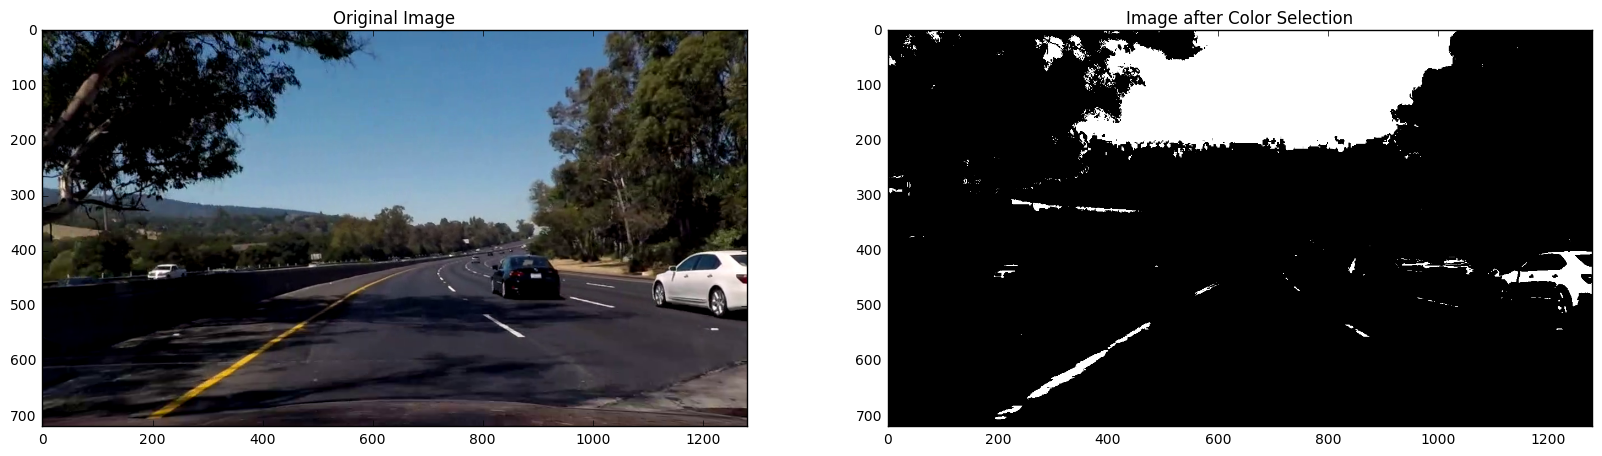

In [18]:
plot_on_subplots([image, get_color_selection(image)], ["Original Image", "Image after Color Selection"], cmap="gray")

In [19]:
def get_binary_image(image):
    """Combines both gradient and color channel thresholds
    to create a binary image. 
    
    Parameters: 
        image -- color image to be converted to a binary image
    """
    
    sobel_binary = get_sobel_binary(image)
    
    s_channel_binary = get_hls_channel_binary(image)

    l_channel_binary = get_hls_channel_binary(image, channel_name="l", thresh_min=200)

    gray_scale_thresholded_image = get_grayscale_thresholded_img(image)
        
    color_sel = get_color_selection(image)

    combined_binary = np.zeros_like(s_channel_binary)

    combined_binary[ (color_sel == 255) | ((s_channel_binary == 1) & (l_channel_binary == 1)) 
                    | ((sobel_binary == 1) & (gray_scale_thresholded_image == 1)) | (l_channel_binary == 1)] = 1
    
    return combined_binary

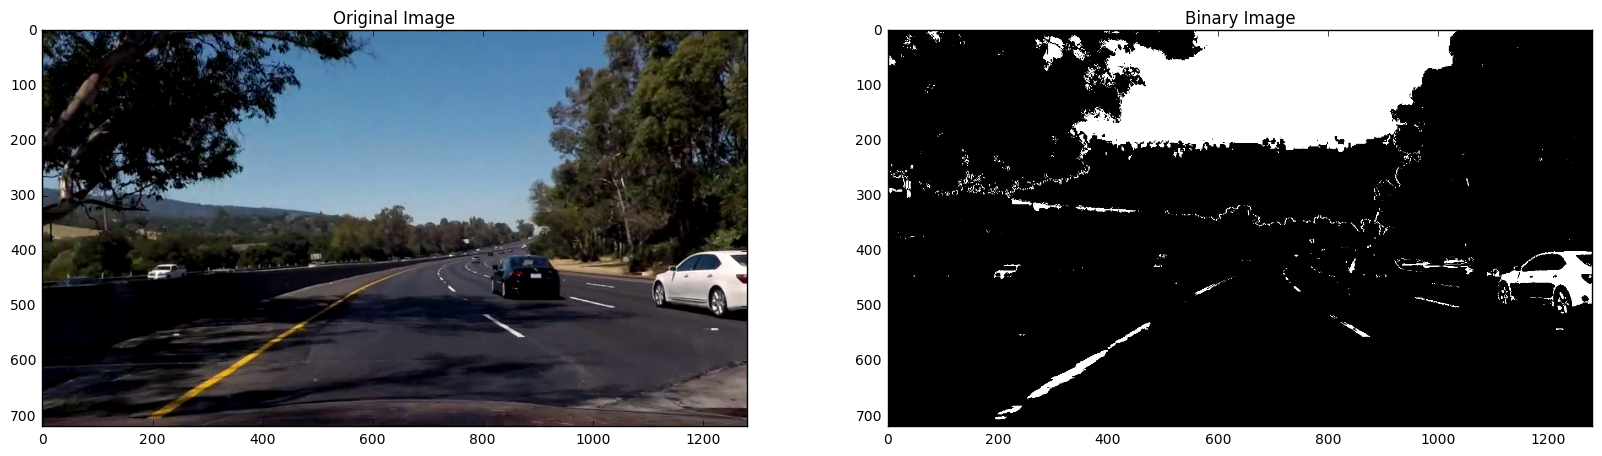

In [20]:
bin_image = get_binary_image(image)
plot_on_subplots([image, bin_image], ["Original Image", "Binary Image"], cmap="gray")

## Region of Interest Selection

In [21]:
def select_region_of_interest(image, plot=False):
    """
        Given an image, this function returns an image
        with only the part which is likely to contain lane lines
        not masked out
    """
    bottom_left = (image.shape[1] * 0.15, image.shape[0])
    bottom_right = (image.shape[1] * 0.93, image.shape[0])

    top_left = (image.shape[1] * 0.4 , image.shape[0]/2)
    top_right = (image.shape[1] * 0.6 , image.shape[0]/2)
    
    white = np.zeros_like(image)
    points = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)
    cv2.fillPoly(white, points , 255)
    
    masked_image = cv2.bitwise_and(image, white)
    
    if(plot):
        masked_image = cv2.bitwise_or(masked_image, cv2.polylines(masked_image, points, False, 255))

    return masked_image

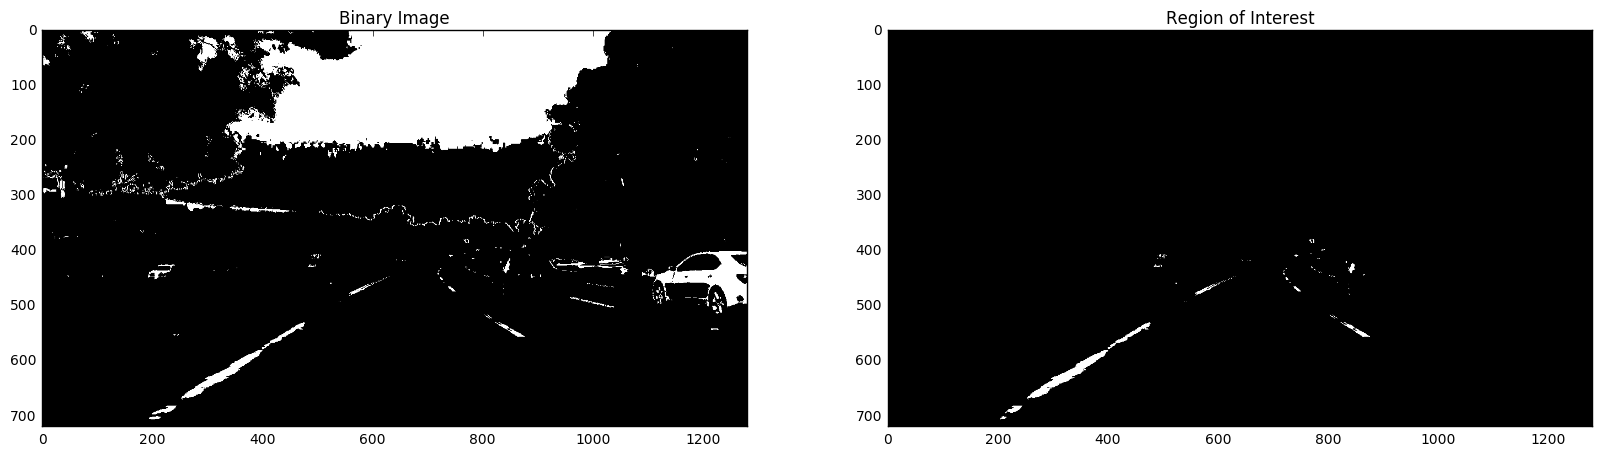

In [22]:
roi_image = select_region_of_interest(bin_image)
plot_on_subplots([bin_image, roi_image], ["Binary Image", "Region of Interest"], cmap="gray")

In [23]:
# Hough transform parameters
rho = 1 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 30     # minimum number of votes (intersections in Hough grid cell)
min_line_length = 1 # minimum number of pixels making up a line
max_line_gap = 5    # maximum gap in pixels between connectable line segments

gaussian_kernel_size = 5

canny_low_threshold = 50
canny_high_threshold = 150


In [24]:
def get_single_line(lines, y_min, y_max):
    """
        Given a set of lines, finds the average slope and average y intercept
        Using these values of average slope and y intercept,
        it finds the x values for the corresponding values of y_min and y_max
        
        and returns the four coordinates as the coordinates of a single line
    """
    points = []
    total_slope = 0
    total_y_intercept = 0
    n = len(lines)
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = (y2 - y1)/(x2 - x1)
            total_slope += slope
            total_y_intercept += (y1 - slope * x1)
    
    average_slope = total_slope/n
    average_y_intercept = total_y_intercept/n
    
    x1 = int((y_min - average_y_intercept)/average_slope)
    x2 = int((y_max - average_y_intercept)/average_slope)
    
    return (x1, y_min,x2, y_max)

In [25]:
def draw_single_line(img, line, color, thickness):
    """Uses cv2.line to draw the `line` on the `img`
    
        Parameters:
            img -- image which is to be mutated with the lines
            line -- [x1, y1, x2, y2] form of a line
            color -- requested color in which the line is to be drawn
            thickness -- requested thickness in which the line is to be drawn
    """
    x1, y1, x2, y2 = line
    cv2.line(img, (x1, y1), (x2, y2), color, thickness)

In [26]:
def find_slope(line):
    """
        Parameter:
            line -- [[x1, y1, x2, y2]] form of a line
        Returns:
            slope calculated by (y2-y1)/(x2-x1)
    """
    return (line[0][3]-line[0][1])/(line[0][2]-line[0][0])

In [27]:
def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    The hough lines are filtered by their slopes to determine the lines which are in 
    the left lane line and those which are in the right lane line.
    
    Parameters:
        img -- The blank image on which to draw the lane lines
        lines -- the coordinates of the hough lines for the image
        color -- requested color in which the lines are to be drawn
        thickness -- requested thickness for the lines to be drawn
        
    Returns:
        [line1, line2] where line1 and line2 are the coordinates of the
        ends of each line
    """
    
    # Define the y extent of the lane lines
    y_min = int(img.shape[0] * 0.7) 
    y_max = img.shape[0]
    
    positive_slopes = list(filter(lambda line: (find_slope(line) > 0.5) and (find_slope(line) < 0.9) , lines))
                                                                              
    negative_slopes = list(filter(lambda line: (find_slope(line) < -0.5) and (find_slope(line) > -0.9) , lines))
    
    line1 = None
    line2 = None
    
    if(len(positive_slopes) > 0):
        line1 = get_single_line(positive_slopes, y_min, y_max)
        draw_single_line(img, line1, color, thickness)
        
    if(len(negative_slopes) > 0):
        line2 = get_single_line(negative_slopes, y_min, y_max)
        draw_single_line(img, line2, color, thickness)
    
    ret = [None, None]
    if(line1):
        ret[0] = line1
    else:
        return None
    
    if(line2):
        ret[1] = line2
    else:
        return None
    
    return ret

In [28]:
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros(img.shape, dtype=np.uint8)
    lines = draw_lines(line_img, lines, thickness=5)
    return lines, line_img

In [29]:
def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines function, An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

In [30]:
def get_blank_image(image):
    """
        Return a blank image with the same dimensions as
        the input image
    """
    return np.zeros(image.shape, dtype=np.uint8)

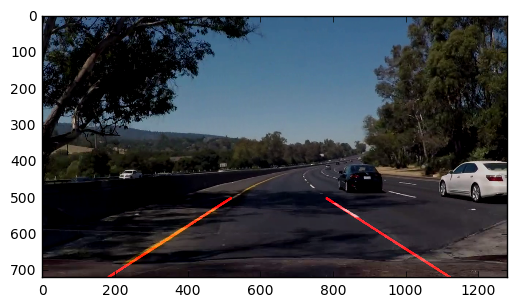

In [31]:
lines, lines_image = hough_lines(roi_image, rho=rho, theta=theta, threshold=threshold, min_line_len=min_line_length, max_line_gap=max_line_gap)
colored_lines_image = np.dstack((lines_image, get_blank_image(lines_image), get_blank_image(lines_image)))
final = weighted_img(colored_lines_image, mpimg.imread(glob.glob("test_images/*")[0]))
plt.imshow(final)

In [32]:
def compute_transformation_matrix(image, hough_lines):
    """Given the image and hough lines for lane lines in the image,
    compute the transformation matrix to perform a perspective transform for
    viewing the lane line from above.
    
    Parameters: 
        image: image with hough lines drawn on it.
        hough_lines: Coordinates of the two lines
    
    """
    if(not hough_lines):
        return None, image
    
    # Decide the final hieght of the transformed points
    y_limit = image.shape[0] * 0.4
    
    # Determine the original and destination points based on the hough lines
    line1, line2 = lines
    
    # Top Right, # Bottom Right, # Top left, # Bottom left
    original_img_pts = [[line1[0], line1[1]], [line1[2], line1[3]], [line2[0], line2[1]], [line2[2], line2[3]]]
    
    destination_pts = [[line1[2], y_limit], [line1[2], line1[3]], [line2[2], y_limit], [line2[2], line2[3]]]
    
    # Define calibration box in source(original) and destination(warped/desired) image
    
    image_shape = (image.shape[1], image.shape[0])
    
    # Four source coordinates
    src = np.float32(original_img_pts)
    
    # Four desired points 
    dst = np.float32(destination_pts)
    
    # Compute the perspective transformation matrix
    M = cv2.getPerspectiveTransform(src, dst)
    
    # Compute the inverse perspective transformation matrix
    M_inv = cv2.getPerspectiveTransform(dst, src)
    
    return (M, M_inv)

In [33]:
def get_transformation_matrix(image, plot=False):
    """Given an image, find the hough lines, and obtain the transformation 
    and inverse transformation matrices to perform a perspective transform on the image 
    to view the lane lines from above
    
    Parameters:
        image -- image with lane lines that are preferably straight
    """
    
    image = undistort(image)
    
    bin_image = get_binary_image(image)
    
    roi_image = select_region_of_interest(bin_image)
    
    lines, lines_image = hough_lines(roi_image, rho=rho, theta=theta, threshold=threshold, min_line_len=min_line_length, max_line_gap=max_line_gap)
    
    M, M_inv = compute_transformation_matrix(image, lines)
    
    if(plot):
        colored_lines_image = np.dstack((lines_image, get_blank_image(lines_image), get_blank_image(lines_image)))

        final = weighted_img(colored_lines_image, image)

        persp = transform_perspective(final, M)

        plot_on_subplots([final, persp], ["Source Points in Perspective Transform", "Destination Points in Perspective Transform"])
    
    return (M, M_inv)

In [34]:
def transform_perspective(image, M):
     return cv2.warpPerspective(image, M, (image.shape[1], image.shape[0]), flags=cv2.INTER_LINEAR)

In [35]:
def get_lane_lines_base(image):
    """
        Input: image which is a binary thresholded image and perspective transformed
        Returns: Coordinates of the base of the lane line (left, right)
    """
    histogram = np.sum(image[image.shape[0]/2:,:], axis=0)
    
    indexes = find_peaks_cwt(histogram, np.arange(1, 550))
    
    return [(indexes[0], image.shape[0]), (indexes[-1], image.shape[0])]

In [36]:
# Calculate the transformation matrix and inverse transformation matrix
test_image = plt.imread(glob.glob("test_images/*")[2])
M, M_inv = get_transformation_matrix(test_image)

In [37]:
def get_lane_pixels(image, lane_base):
    """
        Given the coordinate of the base of the lane
        and the image, use a window of size 100 px to find 
        all the pixels in that lane
        
        Parameters:
            image -- binary, perspective transformed image
            lane base -- coordinates (x,y) of the base of the lane line
        
        Returns:
            x,y -- indices of all pixels that belong to that lane line
    """
    
    window_size = 100 * 2
    
    x_base = lane_base[0]
    
    if(x_base > window_size):
        window_low = x_base - window_size/2
    else:
        window_low = 0
        
    window_high = x_base + window_size/2
    
    # Define a region
    window = image[:, window_low:window_high]

    # Find the coordinates of the white pixels in this region
    x, y = np.where(window == 1)
    
    # Add window low as an offset
    y += np.uint64(window_low)
    
    return (x, y)


In [38]:
def get_curved_lane_line(pixels):
    """
        Given pixels which are the x,y indices of 
        the pixels that correspond to the lane, 
        return a 2nd order polynomial that fits those pixels
    """
    x, y = pixels
    degree = 2
    return np.polyfit(x, y, deg=degree)

In [39]:
def draw_curved_line(image, line):
    """
    Parameters:
        image -- Image on which the lane lines are to be drawn
        line -- polynomial coefficients representing this line
    """
    
    p = np.poly1d(line)
    x = list(range(0, image.shape[0]))
    y = list(map(int, p(x)))
    pts = np.array([[_y,_x] for _x, _y in zip(x, y)])
    
    pts = pts.reshape((-1,1,2))
    
    cv2.polylines(image, np.int32([pts]), False, color=(255,0,0), thickness=50)
    return pts

In [40]:
def calculate_rad_curvature(image, pixels):
    """
    Calculate the radius of curvature for the lane line
    
        Parameters:
            image
            pixels: x,y coordinates of the pixels that belong to the lane line
    """
    y, x = pixels
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/image.shape[1] # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meteres per pixel in x dimension
    
    y_eval = np.max(y)

    fit = np.polyfit(y*ym_per_pix, x*xm_per_pix, 2)
    
    return int(((1 + (2*fit[0]*y_eval + fit[1])**2)**1.5) \
                             /np.absolute(2*fit[0]))

In [41]:
def compute_distance_from_lane(image, left_base, right_base):
    """
        Compute the distance of the car from the center of the lane
        
        Parameters:
            image
            left_base -- coordinates (x,y) of the base of the left lane
            right_base -- coordinates (x,y) of the base of the right lane
    """
    
    xm_per_pix = 3.7/700 # meteres per pixel in x dimension
    
    image_center = (image.shape[1]/2, image.shape[0])
    
    car_middle_pixel = int((left_base[0] + right_base[0])/2)
    
    return float("{0:.2f}".format((car_middle_pixel - image_center[0]) * xm_per_pix))

In [42]:
def draw_lane_lines(image, left_pixels, right_pixels, left_base, right_base):
    """
        Draws left and right lane lines on the image
    """
    
    image = np.zeros_like(image)
    
    line1 = get_curved_lane_line(left_pixels)
    line1_pts = draw_curved_line(image, line1)
    left_line_curvature = calculate_rad_curvature(image, left_pixels)
    
    line2 = get_curved_lane_line(right_pixels)
    line2_pts = draw_curved_line(image, line2)
    left_line_curvature = calculate_rad_curvature(image, right_pixels)
    
    top_points = [line1_pts[-1], line2_pts[-1]]
    base_points = [line1_pts[0], line2_pts[0]]
    
    distance_from_left = compute_distance_from_lane(image, left_base, right_base)
    
    # Fill in the detected lane
    cv2.fillPoly(image, [np.concatenate((line2_pts, line1_pts, top_points,base_points ))], color=(152,251,152))
    
    return (image, left_line_curvature, left_line_curvature, distance_from_left)

In [43]:
def process_image(image):
    """
        Return the result of passing the image
        through the pipeline
    """
    
    try:
        blurred_img = gaussian_blur(image)

        undistorted_image = undistort(blurred_img)

        binary_image = get_binary_image(undistorted_image)

        roi_image = select_region_of_interest(binary_image)

        persp_transform = transform_perspective(roi_image, M)

        lane_base = get_lane_lines_base(persp_transform)

        left_base, right_base = lane_base

        left_pixels = get_lane_pixels(persp_transform, left_base)

        right_pixels = get_lane_pixels(persp_transform, right_base)

        warped_with_lane_lines, left_curv, right_curv, dist_from_center = draw_lane_lines(image, left_pixels, right_pixels, left_base, right_base)

        lane_lines = transform_perspective(image=warped_with_lane_lines, M=M_inv)

        final = weighted_img(lane_lines, image)

        cv2.putText(final, "Lane Curvature: " + str(left_curv) + " (m)", (100, 100), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255))
        cv2.putText(final, "Distance from center: " + str(dist_from_center) + " (m)", (100, 150), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255))
        
    except Exception as e:
        print(e)
        return image

    return final


In [47]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [48]:
def process(image):
    return process_image(image)

In [49]:
white_output = 'p4.mp4'
clip1 = VideoFileClip("./project_video.mp4")
white_clip = clip1.fl_image(process) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video p4.mp4
[MoviePy] Writing video p4.mp4


 49%|███████████████████                    | 615/1261 [10:49<13:29,  1.25s/it]

expected non-empty vector for x


100%|█████████████████████████████████████▉| 1260/1261 [23:37<00:01,  1.26s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: p4.mp4 

Wall time: 23min 40s


In [50]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [ ]:
p4_challenge_output = 'p4-challenge.mp4'
clip1 = VideoFileClip("./challenge_video.mp4")
p4_challenge_clip = clip1.fl_image(process) #NOTE: this function expects color images!!
%time p4_challenge_clip.write_videofile(p4_challenge_output, audio=False)

In [52]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(p4_challenge_output))

In [ ]:
p4_hard_challenge_output = 'p4-hard-challenge.mp4'
clip1 = VideoFileClip("./harder_challenge_video.mp4")
p4_hard_challenge_clip = clip1.fl_image(process) #NOTE: this function expects color images!!
%time p4_hard_challenge_clip.write_videofile(p4_hard_challenge_output, audio=False)

In [52]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(p4_hard_challenge_output))